<a href="https://colab.research.google.com/github/JackBstn/NLP/blob/main/chronos_multivariate_neural_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chronos Multivariate Neural Network for Stock Price Prediction

This notebook demonstrates the use of the Chronos forecasting model
in conjunction with a custom neural network to predict stock prices based on a *multivariate time-series*.

The notebook automatically installs the necessary dependencies and downloading historical stock data from Yahoo Finance.
The data includes various dimensions such as Open, High, Low, and Close prices.

The *goal of the neural network* is to join the predictions made by the Chronos model for each dimension
into a single prediction for the next day's closing price.


#### Dataset preparation

A sliding window approach is used to generate the dataset.
For each window, the Chronos model predicts the next day's value of each dimension.
These predictions are used as inputs to the neural network, while the actual closing price is used as target.

#### Neural Network Training

1. Data is normalized, split into training and validation sets, and converted to PyTorch tensors
2. A neural network with three fully connected layers is defined for price prediction (input: covariate predictions, output: closing price)
3. The network is trained using the training dataset, with early stopping to prevent overfitting

#### Evaluation

The trained model is tested on new data to predict future stock prices.
The predictions are compared against the actual prices and the predictions made by the Chronos model alone,
applied to the closing price directly.

Various metrics such as MSE, RMSE, MAPE, and MASE are computed to evaluate the model's performance.
The results are compared between Chronos+NN and Chronos-only approaches.


### Install Dependencies and download data

In [1]:
!pip install torch transformers chronos yfinance pandas matplotlib
!pip install git+https://github.com/amazon-science/chronos-forecasting.git

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 30.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 37.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 58.5 MB/s eta 0:00:00
  Created wheel for chronos: filename=chronos-0.3-py3-none-any.whl size=7374 sha256=045dca85c1767a674257cad4c0499ceb010ab919fdb5833b0581d648eb161f15
  Stored in d

In [2]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from chronos import BaseChronosPipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.data import DataLoader, TensorDataset

seed = 343126


def reset_seed():
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)


DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

#### Download data

In [3]:
# Download Yahoo Finance data
symbol = "AAPL"  # Replace with desired stock symbol
data = yf.download(symbol, start="2010-01-01", end="2023-12-31", progress=False)

# Use 'Close' column as time series to forecast
df = data.reset_index()
covariates = df[["Open", "High", "Low", "Close"]].values
close_prices = df["Close"].values

#### Generate dataset for NN training

In [4]:
# Chronos Model
pipeline = BaseChronosPipeline.from_pretrained("amazon/chronos-t5-tiny", device_map=DEVICE, torch_dtype=torch.bfloat16)


# Sliding window to generate the dataset
def generate_dataset_with_chronos(covariates, close_prices, pipeline, window_size=50):
    """ Generate dataset using Chronos for forecasting: for each covariate, predict the next day closing price.
    :param covariates: covariates data
    :param close_prices: closing prices data
    :param pipeline: Chronos model to use for forecasting
    :param window_size: Size of the sliding window
    :return: Tuple with input and output datasets (numpy arrays)
    """

    X = []
    Y = []
    for t in range(len(covariates) - window_size):
        # Covariate window
        window = covariates[t:t + window_size]

        # Chronos forcasting for each covariate
        means = []
        for i in range(window.shape[1]):  # Iterate over each covariate
            context = torch.tensor(window[:, i])  # Univariate series
            forecast = pipeline.predict(context=context, prediction_length=1)  # Predict the next day
            mean_forecast = np.mean(forecast[0].numpy())  # Distribution mean
            means.append(mean_forecast)

        # Input: Mean of covariates
        X.append(means)

        # Ground truth: Real closing price of the next day
        Y.append(close_prices[t + window_size])

    return np.array(X), np.array(Y)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.14k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/33.6M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/142 [00:00<?, ?B/s]

In [5]:
reset_seed()  # For reproducibility

# Generate dataset
X, Y = generate_dataset_with_chronos(covariates, close_prices, pipeline, window_size=50)

# Print dataset dimensions for confirmation
print(f"Dataset X shape: {X.shape}")
print(f"Dataset Y shape: {Y.shape}")

Dataset X shape: (3472, 4)
Dataset Y shape: (3472, 1)


### Neural Network training

#### Dataset preparation: scale, split, and convert to tensors

In [6]:
reset_seed()  # For reproducibility

# Normalize covariates
scaler_x = StandardScaler()
X = scaler_x.fit_transform(X)

# Normalize target variable
scaler_y = StandardScaler()
Y = scaler_y.fit_transform(Y)

# Split data into training and validation
X_train_split, X_val_split, Y_train_split, Y_val_split = train_test_split(X, Y, test_size=0.2, random_state=seed)

# Convert to PyTorch tensors
X_train_split = torch.tensor(X_train_split, dtype=torch.float32)
X_val_split = torch.tensor(X_val_split, dtype=torch.float32)
Y_train_split = torch.tensor(Y_train_split, dtype=torch.float32)
Y_val_split = torch.tensor(Y_val_split, dtype=torch.float32)

# Print dimensions for confirmation
print(f"X_train shape: {X_train_split.shape}, Y_train shape: {Y_train_split.shape}")
print(f"X_val shape: {X_val_split.shape}, Y_val shape: {Y_val_split.shape}")

X_train shape: torch.Size([2777, 4]), Y_train shape: torch.Size([2777, 1])
X_val shape: torch.Size([695, 4]), Y_val shape: torch.Size([695, 1])


#### Neural Network definition

In [7]:
class PricePredictionNN(nn.Module):
    """
    Neural Network for price prediction.
    Architecture: 3 fully connected layers with ReLU activation and dropout.
    """

    def __init__(self, input_size, hidden_size_1, hidden_size_2, output_size):
        super(PricePredictionNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size_1)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.1)
        self.fc2 = nn.Linear(hidden_size_1, hidden_size_2)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.1)
        self.fc3 = nn.Linear(hidden_size_2, output_size)

    def forward(self, x):
        x = self.dropout1(self.relu1(self.fc1(x)))
        x = self.dropout2(self.relu2(self.fc2(x)))
        x = self.fc3(x)
        return x

#### Neural Network training

In [8]:
# Hyperparameters
LR = 0.001  # Initial learning rate
WEIGHT_DECAY = 4e-5  # Regularization
STEP_SIZE = [150, 300, 600]  # Number of epochs before decreasing LR
GAMMA = 0.1  # Multiplicative factor for learning rate step-down

Epoch 0/1000 (LR=0.001), Training Loss: 0.0718, Validation Loss: 0.0023
Epoch 1/1000 (LR=0.001), Training Loss: 0.0013, Validation Loss: 0.0008
Epoch 2/1000 (LR=0.001), Training Loss: 0.0011, Validation Loss: 0.0009
Epoch 3/1000 (LR=0.001), Training Loss: 0.0010, Validation Loss: 0.0008
Epoch 4/1000 (LR=0.001), Training Loss: 0.0010, Validation Loss: 0.0009
Epoch 5/1000 (LR=0.001), Training Loss: 0.0010, Validation Loss: 0.0011
Training stopped at epoch 6 because training loss < 0.001


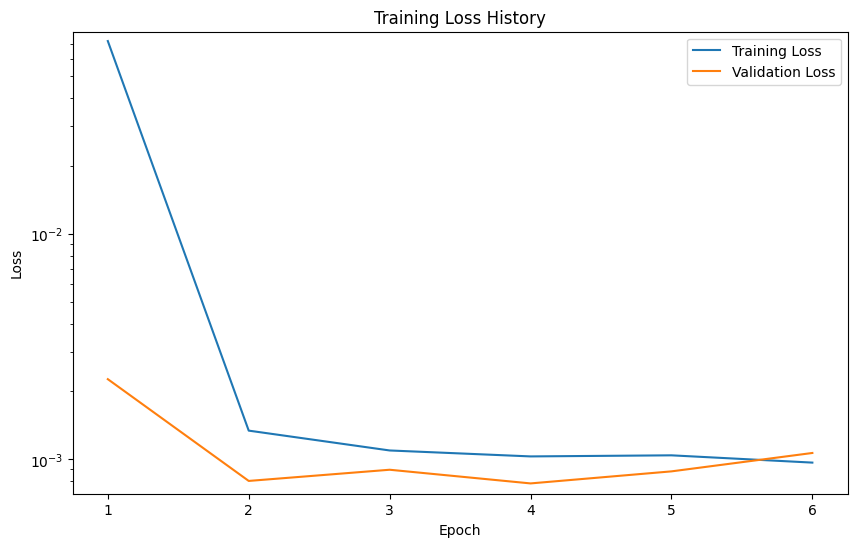

In [9]:
reset_seed()  # For reproducibility

# Model creation
input_size = X.shape[1]  # Feature number
hidden_size_1 = 128  # Number of hidden units in first hidden layer
hidden_size_2 = 64  # Number of hidden units in second hidden layer
output_size = 1  # Output size (1 for regression)
model = PricePredictionNN(input_size, hidden_size_1, hidden_size_2, output_size)

# Optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY, eps=1e-4)
criterion = nn.MSELoss()  # Mean Squared Error because it's a regression problem
scheduler = MultiStepLR(optimizer, milestones=STEP_SIZE, gamma=GAMMA)

# Create DataLoader for training
batch_size = 32
train_dataset = TensorDataset(X_train_split, Y_train_split)
val_dataset = TensorDataset(X_val_split, Y_val_split)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Early stopping
best_loss = float("inf")
patience = 100  # Maximum number of epochs without improvement
patience_counter = 0

loss_history = []
loss_history_val = []

# Initialize training
num_epochs = 1000
model.train()

for epoch in range(num_epochs):
    train_loss = 0.0

    # Training loop
    for batch_X, batch_Y in train_loader:
        optimizer.zero_grad()

        # Forward pass
        predictions = model(batch_X)
        loss = criterion(predictions, batch_Y)

        # Backpropagation and optimization
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)  # Average loss per batch
    loss_history.append(train_loss)

    # Validation loop
    model.eval()
    val_loss = 0.0
    val_predictions_list = []

    with torch.no_grad():
        for batch_X, batch_Y in val_loader:
            val_predictions = model(batch_X)
            val_predictions_list.append(val_predictions.numpy())  # Save predictions

            loss = criterion(val_predictions, batch_Y)
            val_loss += loss.item()

    # Convert the list to a numpy array
    val_predictions = np.concatenate(val_predictions_list, axis=0)

    # Convert back to original scale
    val_predictions_original = scaler_y.inverse_transform(val_predictions)

    val_loss /= len(val_loader)  # Average loss per batch
    loss_history_val.append(val_loss)

    # Learning rate scheduler step
    scheduler.step()

    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch}/{num_epochs} (LR={current_lr}), Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

    # Early Stopping
    if val_loss < best_loss:
        best_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "nn_model.pth")  # Save the best model
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print(f"Early stopping at epoch {epoch + 1}")
        break

    # Interrupt training if loss drops below 0.001 (early stopping)
    if train_loss < 0.001:
        print(f"Training stopped at epoch {epoch + 1} because training loss < 0.001")
        break

# Plot loss history
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(loss_history) + 1), loss_history, label="Training Loss")
plt.plot(range(1, len(loss_history_val) + 1), loss_history_val, label="Validation Loss")
plt.yscale("log")  # Use log scale to better see the loss decrease
plt.ylim([min(loss_history_val + loss_history) * 0.9, max(loss_history) * 1.1])  # Auto-adjust Y scale
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss History")
plt.legend()
plt.show()

In [10]:
# Save the model
torch.save(model.state_dict(), "nn_model.pth")

# Load the model
# model.load_state_dict(torch.load("best_model.pth"))

#### Result comparison (Chronos+NN vs Chronos-only)

<ipython-input-15-026c49d982a9>:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("nn_model.pth"))


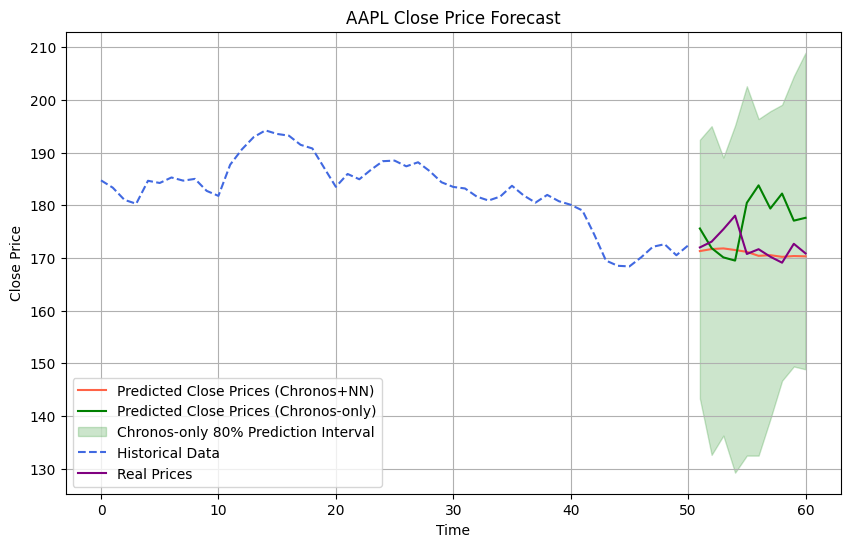

In [15]:
# Test on new data (from 2024), plotting the true value, the value predicted by our NN and the value predicted by Chronos, to compare them
reset_seed()  # For reproducibility

# New data
new_data = yf.download(symbol, start="2024-01-01", end="2024-03-31", progress=False)
new_data = new_data.reset_index()
new_covariates = new_data[["Open", "High", "Low", "Close"]].values
new_close_prices = new_data["Close"].values

prediction_length = 10  # Number of days to predict

# Split the data to "context" and "test" data
data_to_predict = new_covariates[-prediction_length:]
values_to_predict = new_close_prices[-prediction_length:]
context_covariates = new_covariates[:-prediction_length]
context_close_prices = new_close_prices[:-prediction_length]

# Apply Chronos on each covariate (each column of new_covariates)
covariate_predictions = []
for i in range(data_to_predict.shape[1]):
    context = torch.tensor(context_covariates[:, i])  # Univariate series
    forecast = pipeline.predict(context=context, prediction_length=prediction_length)  # Predict the next days
    means = np.mean(forecast[0].numpy(), axis=0)  # Distribution mean
    covariate_predictions.append(means)

# Scale and convert to PyTorch tensor
covariate_predictions = scaler_x.transform(np.array(covariate_predictions).T)
covariate_predictions = torch.tensor(covariate_predictions, dtype=torch.float32)

# Apply the NN model to join the covariate predictions (5 x prediction_length) into a univariate prediction (prediction_length)
model.load_state_dict(torch.load("nn_model.pth"))
model.eval()
with torch.no_grad():
    univariate_predictions = model(covariate_predictions)

# Reverse the scaling
univariate_predictions = scaler_y.inverse_transform(univariate_predictions)

# Data index for plotting context and test data
historical_index = np.arange(len(context_close_prices))  # Historical data
test_index = np.arange(len(context_close_prices), len(context_close_prices) + prediction_length)  # Test data

# For comparison, also compute the forecast using Chronos only applied to the close price directly

# Reduce context and prediction length for Chronos
chronos_context = torch.tensor(context_close_prices, dtype=torch.float32)
chronos_forecast = pipeline.predict(context=chronos_context, prediction_length=prediction_length)
low, median, high = np.quantile(chronos_forecast[0].numpy(), [0.1, 0.5, 0.9], axis=0)
chronos_only_forecast = np.mean(chronos_forecast[0].numpy(), axis=0)

# Plot the forecasts
plt.figure(figsize=(10, 6))

plt.plot(test_index, univariate_predictions, color="tomato", label="Predicted Close Prices (Chronos+NN)")  # Chronos+NN forecast
plt.plot(test_index, chronos_only_forecast, color="green", label="Predicted Close Prices (Chronos-only)")  # Chronos-only forecast
plt.fill_between(test_index, low, high, color="green", alpha=0.2, label="Chronos-only 80% Prediction Interval")  # Chronos-only confidence

# Plot the history
plt.plot(historical_index, context_close_prices, color="royalblue", label="Historical Data", linestyle='--')  # Historical data

# Plot the "real" line
plt.plot(test_index, values_to_predict, color="purple", label="Real Prices")  # Real data, only for the test period

plt.title(f"{symbol} Close Price Forecast")
plt.xlabel("Time")
plt.ylabel("Close Price")
plt.legend()
plt.grid()
plt.show()

In [12]:
from scipy.stats import gmean


# Evaluation metrics
def mase(y_true, y_pred, y_train):
    """
    Compute the Mean Absolute Scaled Error (MASE)
    y_true: true values
    y_pred: predicted values
    y_train: historical series to calculate the naive benchmark
    """

    naive_forecast = np.abs(np.diff(y_train)).mean()  # Naive Model: mean differences between successive values
    return np.mean(np.abs(y_true - y_pred)) / naive_forecast


def compute_metrics(y_true, y_pred, y_train):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    mase_score = mase(y_true, y_pred, y_train)
    return { "MSE": mse, "RMSE": rmse, "MAPE": mape, "MASE": mase_score }


def agg_relative_score(model_df: pd.DataFrame, baseline_df: pd.DataFrame):
    relative_score = model_df / baseline_df  # Ratio between model and baseline
    return relative_score.agg(gmean)  # Geometric mean of improvements


# Compute metrics
results = { }
results['Neural Network'] = compute_metrics(values_to_predict, univariate_predictions, context_close_prices.reshape(-1))
results['Chronos'] = compute_metrics(values_to_predict, chronos_only_forecast, context_close_prices.reshape(-1))
results = pd.DataFrame(results).T

print("PERFORMANCE METRICS:")
print(results)

# Compute relative performance
relative_scores = agg_relative_score(results.loc['Neural Network'], results.loc['Chronos'])
print("-------------------------------------------------")
print("SCALING PERFORMANCE (Preprocessing vs Chronos Only Close):")
print(relative_scores)

PERFORMANCE METRICS:
                      MSE      RMSE      MAPE      MASE
Neural Network   6.696888  2.587835  1.042020  1.097791
Chronos         67.838280  8.236400  3.346912  3.470375
-------------------------------------------------
SCALING PERFORMANCE (Preprocessing vs Chronos Only Close):
MSE     0.098718
RMSE    0.314195
MAPE    0.311338
MASE    0.316332
dtype: float64


<ipython-input-12-82c8efa9003b>:27: FutureWarning: using <function gmean at 0x7c277f66be20> in Series.agg cannot aggregate and has been deprecated. Use Series.transform to keep behavior unchanged.
  return relative_score.agg(gmean)  # Geometric mean of improvements
